In [1]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('leakage_dataset_train_1000.csv')

x1_train, x2_train, x3_train, x4_train = np.array(df_train['mfc1']), np.array(df_train['mfc2']), np.array(df_train['mfc3']), np.array(df_train['mfc4'])
y1_train, y2_train = np.array(df_train['y1']), np.array(df_train['y2'])

diff = np.mean(x4_train-(x1_train+x2_train+x3_train)/3)
x4_train=x4_train-diff

X_train, Y_train = np.column_stack((x1_train,x2_train,x3_train,x4_train)), np.column_stack((y1_train,y2_train))

X_train=pd.DataFrame(X_train)
X_train.head()

,0,1,2,3
0,0.292939,0.200913,0.179114,0.279875
1,0.331997,0.292966,0.169223,0.158656
2,0.267616,0.188200,0.199169,0.297856
3,0.363582,0.182521,0.165669,0.241069
4,0.142597,0.536641,0.146298,0.127305


In [4]:
Y_train=pd.DataFrame(Y_train)
Y_train.head()

,0,1
0,-0.415261,0.014355
1,-0.067510,0.823864
2,-0.414509,-0.044448
3,-0.692025,0.147275
4,0.776795,0.584189


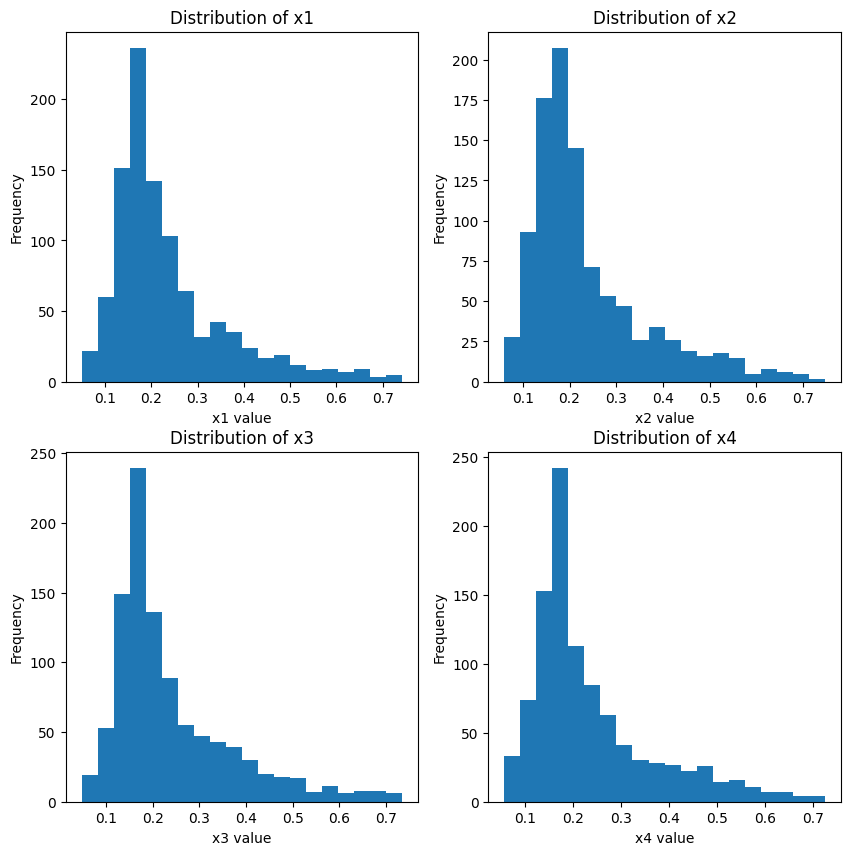

In [3]:
fig, axs = plt.subplots(2,2,figsize=(10,10))

axs[0,0].hist(x1_train,bins=20)
axs[0,0].set_xlabel('x1 value')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('Distribution of x1')

axs[0,1].hist(x2_train,bins=20)
axs[0,1].set_xlabel('x2 value')
axs[0,1].set_ylabel('Frequency')
axs[0,1].set_title('Distribution of x2')

axs[1,0].hist(x3_train,bins=20)
axs[1,0].set_xlabel('x3 value')
axs[1,0].set_ylabel('Frequency')
axs[1,0].set_title('Distribution of x3')

axs[1,1].hist(x4_train,bins=20)
axs[1,1].set_xlabel('x4 value')
axs[1,1].set_ylabel('Frequency')
axs[1,1].set_title('Distribution of x4')

plt.show()

In [5]:
df_val = pd.read_csv('leakage_dataset_validation_1000.csv')

x1_test, x2_test, x3_test, x4_test = np.array(df_val['mfc1']), np.array(df_val['mfc2']), np.array(df_val['mfc3']), np.array(df_val['mfc4'])
y1_test, y2_test = np.array(df_val['y1']), np.array(df_val['y2'])

X_test, Y_test = np.column_stack((x1_test,x2_test,x3_test,x4_test)), np.column_stack((y1_test,y2_test))
X_test=pd.DataFrame(X_test)
X_test.head()

,0,1,2,3
0,0.365105,0.187124,0.174338,0.273434
1,0.232170,0.182380,0.209652,0.375799
2,0.156413,0.138725,0.189124,0.515737
3,0.385778,0.174589,0.160180,0.279453
4,0.195498,0.321794,0.287587,0.195121


In [6]:
Y_test=pd.DataFrame(Y_test)
Y_test.head()

,0,1
0,-0.783673,0.115504
1,-0.513497,-0.251715
2,-0.434164,-0.864151
3,-0.765644,0.189038
4,0.595703,0.040648


In [7]:
from tensorflow import keras
from keras import layers
from keras import metrics
import keras_tuner as kt
from keras.layers import Dropout,BatchNormalization

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten(input_shape=(4,)))
        # Tune number of layers in NN
        count = 0 
        for i in range(hp.Int("num_layers", 2, 4)):
            if count==0:
                model.add(
                    layers.Dense(
                        # Tune number of units separately.
                        units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
                        activation=hp.Choice("activation"+str(i),["sigmoid", "tanh","relu"]),
                    )
                )
                model.add(Dropout(hp.Choice(name='dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
            else:
                model.add(
                    layers.Dense(
                        # Tune number of units separately.
                        units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
                        activation=hp.Choice("activation"+str(i),["sigmoid", "tanh","relu"]),
                    )
                )
                model.add(Dropout(hp.Choice(name='dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        model.add(layers.Dense(2))
        # Tune Learning Rate
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
        model.compile(
#             optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            optimizer=hp.Choice("optimizer", ["adam","adadelta","nadam","RMSprop","SGD"]),
            loss=hp.Choice("loss",["mean_absolute_error","mean_squared_error"]),
            metrics=[metrics.MeanAbsoluteError(name='my_mae')]
        )
        return model

    # Tune Model.fit parameters like batch size, epochs etc.
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            X_train,
            Y_train,
            batch_size=hp.Choice("batch_size", [10,50]),epochs=hp.Choice("epochs", [500]),
            **kwargs,
        )

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective=kt.Objective("val_my_mae",direction="min"),
    max_trials=50,
    executions_per_trial=10,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)

In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation0 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
dropout0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation1 (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
dropout1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'ordered': True}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None,

In [9]:
tuner.search(X_train,Y_train,validation_data=(X_test, Y_test))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |?                 |num_layers
448               |?                 |units_0
tanh              |?                 |activation0
0.6               |?                 |dropout0
448               |?                 |units_1
sigmoid           |?                 |activation1
0.1               |?                 |dropout1
0.0039659         |?                 |lr
RMSprop           |?                 |optimizer
mean_absolute_e...|?                 |loss

Epoch 1/500
100/100 [==============================] - 18s 50ms/step - loss: 0.4275 - my_mae: 0.4275 - val_loss: 0.2727 - val_my_mae: 0.2727
Epoch 2/500
100/100 [==============================] - 4s 43ms/step - loss: 0.2343 - my_mae: 0.2343 - val_loss: 0.2447 - val_my_mae: 0.2447
Epoch 3/500
100/100 [==============================] - 1s 6ms/step - loss: 0.1805 - my_mae: 0.1805 - val_loss: 0.1478 - val_my_mae: 0.1478
Epoch 4/500
100/100 [===========

100/100 [==============================] - 0s 5ms/step - loss: 0.0840 - my_mae: 0.0840 - val_loss: 0.0629 - val_my_mae: 0.0629
Epoch 114/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0836 - my_mae: 0.0836 - val_loss: 0.0628 - val_my_mae: 0.0628
Epoch 115/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0830 - my_mae: 0.0830 - val_loss: 0.0690 - val_my_mae: 0.0690
Epoch 116/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0824 - my_mae: 0.0824 - val_loss: 0.0663 - val_my_mae: 0.0663
Epoch 117/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0841 - my_mae: 0.0841 - val_loss: 0.0580 - val_my_mae: 0.0580
Epoch 118/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0837 - my_mae: 0.0837 - val_loss: 0.0639 - val_my_mae: 0.0639
Epoch 119/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0823 - my_mae: 0.0823 - val_loss: 0.0605 - val_my_mae: 0.0605
Epoch 120/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0763 - my_mae: 0.0763 - val_loss: 0.0613 - val_my_mae: 0.0613
Epoch 230/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0799 - my_mae: 0.0799 - val_loss: 0.0599 - val_my_mae: 0.0599
Epoch 231/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0791 - my_mae: 0.0791 - val_loss: 0.0740 - val_my_mae: 0.0740
Epoch 232/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0778 - my_mae: 0.0778 - val_loss: 0.0602 - val_my_mae: 0.0602
Epoch 233/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0778 - my_mae: 0.0778 - val_loss: 0.0650 - val_my_mae: 0.0650
Epoch 234/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0766 - my_mae: 0.0766 - val_loss: 0.0674 - val_my_mae: 0.0674
Epoch 235/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0770 - my_mae: 0.0770 - val_loss: 0.0649 - val_my_mae: 0.0649
Epoch 236/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0773 - my_mae: 0.0773 - val_loss: 0.0594 - val_my_mae: 0.0594
Epoch 346/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0740 - my_mae: 0.0740 - val_loss: 0.0634 - val_my_mae: 0.0634
Epoch 347/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0747 - my_mae: 0.0747 - val_loss: 0.0648 - val_my_mae: 0.0648
Epoch 348/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0759 - my_mae: 0.0759 - val_loss: 0.0627 - val_my_mae: 0.0627
Epoch 349/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0753 - my_mae: 0.0753 - val_loss: 0.0605 - val_my_mae: 0.0605
Epoch 350/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0743 - my_mae: 0.0743 - val_loss: 0.0589 - val_my_mae: 0.0589
Epoch 351/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0736 - my_mae: 0.0736 - val_loss: 0.0594 - val_my_mae: 0.0594
Epoch 352/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0724 - my_mae: 0.0724 - val_loss: 0.0632 - val_my_mae: 0.0632
Epoch 462/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0744 - my_mae: 0.0744 - val_loss: 0.0609 - val_my_mae: 0.0609
Epoch 463/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0735 - my_mae: 0.0735 - val_loss: 0.0616 - val_my_mae: 0.0616
Epoch 464/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0741 - my_mae: 0.0741 - val_loss: 0.0612 - val_my_mae: 0.0612
Epoch 465/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0739 - my_mae: 0.0739 - val_loss: 0.0617 - val_my_mae: 0.0617
Epoch 466/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0728 - my_mae: 0.0728 - val_loss: 0.0605 - val_my_mae: 0.0605
Epoch 467/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0749 - my_mae: 0.0749 - val_loss: 0.0645 - val_my_mae: 0.0645
Epoch 468/500
100/100 [====

100/100 [==============================] - 1s 6ms/step - loss: 0.0863 - my_mae: 0.0863 - val_loss: 0.0637 - val_my_mae: 0.0637
Epoch 78/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0858 - my_mae: 0.0858 - val_loss: 0.0725 - val_my_mae: 0.0725
Epoch 79/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0849 - my_mae: 0.0849 - val_loss: 0.0644 - val_my_mae: 0.0644
Epoch 80/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0838 - my_mae: 0.0838 - val_loss: 0.0650 - val_my_mae: 0.0650
Epoch 81/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0842 - my_mae: 0.0842 - val_loss: 0.0655 - val_my_mae: 0.0655
Epoch 82/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0860 - my_mae: 0.0860 - val_loss: 0.0591 - val_my_mae: 0.0591
Epoch 83/500
100/100 [==============================] - 1s 6ms/step - loss: 0.0854 - my_mae: 0.0854 - val_loss: 0.0674 - val_my_mae: 0.0674
Epoch 84/500
100/100 [===========

100/100 [==============================] - 0s 5ms/step - loss: 0.0789 - my_mae: 0.0789 - val_loss: 0.0610 - val_my_mae: 0.0610
Epoch 194/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0790 - my_mae: 0.0790 - val_loss: 0.0653 - val_my_mae: 0.0653
Epoch 195/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0792 - my_mae: 0.0792 - val_loss: 0.0646 - val_my_mae: 0.0646
Epoch 196/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0801 - my_mae: 0.0801 - val_loss: 0.0642 - val_my_mae: 0.0642
Epoch 197/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0786 - my_mae: 0.0786 - val_loss: 0.0653 - val_my_mae: 0.0653
Epoch 198/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0787 - my_mae: 0.0787 - val_loss: 0.0599 - val_my_mae: 0.0599
Epoch 199/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0787 - my_mae: 0.0787 - val_loss: 0.0622 - val_my_mae: 0.0622
Epoch 200/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0769 - my_mae: 0.0769 - val_loss: 0.0623 - val_my_mae: 0.0623
Epoch 310/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0753 - my_mae: 0.0753 - val_loss: 0.0620 - val_my_mae: 0.0620
Epoch 311/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0745 - my_mae: 0.0745 - val_loss: 0.0627 - val_my_mae: 0.0627
Epoch 312/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0766 - my_mae: 0.0766 - val_loss: 0.0617 - val_my_mae: 0.0617
Epoch 313/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0752 - my_mae: 0.0752 - val_loss: 0.0605 - val_my_mae: 0.0605
Epoch 314/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0764 - my_mae: 0.0764 - val_loss: 0.0588 - val_my_mae: 0.0588
Epoch 315/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0751 - my_mae: 0.0751 - val_loss: 0.0638 - val_my_mae: 0.0638
Epoch 316/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0717 - my_mae: 0.0717 - val_loss: 0.0610 - val_my_mae: 0.0610
Epoch 426/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0719 - my_mae: 0.0719 - val_loss: 0.0621 - val_my_mae: 0.0621
Epoch 427/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0760 - my_mae: 0.0760 - val_loss: 0.0616 - val_my_mae: 0.0616
Epoch 428/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0758 - my_mae: 0.0758 - val_loss: 0.0609 - val_my_mae: 0.0609
Epoch 429/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0746 - my_mae: 0.0746 - val_loss: 0.0589 - val_my_mae: 0.0589
Epoch 430/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0738 - my_mae: 0.0738 - val_loss: 0.0675 - val_my_mae: 0.0675
Epoch 431/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0774 - my_mae: 0.0774 - val_loss: 0.0607 - val_my_mae: 0.0607
Epoch 432/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0933 - my_mae: 0.0933 - val_loss: 0.0621 - val_my_mae: 0.0621
Epoch 42/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0939 - my_mae: 0.0939 - val_loss: 0.0827 - val_my_mae: 0.0827
Epoch 43/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0902 - my_mae: 0.0902 - val_loss: 0.0675 - val_my_mae: 0.0675
Epoch 44/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0920 - my_mae: 0.0920 - val_loss: 0.0613 - val_my_mae: 0.0613
Epoch 45/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0924 - my_mae: 0.0924 - val_loss: 0.0703 - val_my_mae: 0.0703
Epoch 46/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0940 - my_mae: 0.0940 - val_loss: 0.0709 - val_my_mae: 0.0709
Epoch 47/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0913 - my_mae: 0.0913 - val_loss: 0.0770 - val_my_mae: 0.0770
Epoch 48/500
100/100 [===========

100/100 [==============================] - 1s 5ms/step - loss: 0.0823 - my_mae: 0.0823 - val_loss: 0.0699 - val_my_mae: 0.0699
Epoch 158/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0797 - my_mae: 0.0797 - val_loss: 0.0613 - val_my_mae: 0.0613
Epoch 159/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0794 - my_mae: 0.0794 - val_loss: 0.0780 - val_my_mae: 0.0780
Epoch 160/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0805 - my_mae: 0.0805 - val_loss: 0.0659 - val_my_mae: 0.0659
Epoch 161/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0794 - my_mae: 0.0794 - val_loss: 0.0693 - val_my_mae: 0.0693
Epoch 162/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0796 - my_mae: 0.0796 - val_loss: 0.0651 - val_my_mae: 0.0651
Epoch 163/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0813 - my_mae: 0.0813 - val_loss: 0.0638 - val_my_mae: 0.0638
Epoch 164/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0774 - my_mae: 0.0774 - val_loss: 0.0567 - val_my_mae: 0.0567
Epoch 274/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0792 - my_mae: 0.0792 - val_loss: 0.0618 - val_my_mae: 0.0618
Epoch 275/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0752 - my_mae: 0.0752 - val_loss: 0.0633 - val_my_mae: 0.0633
Epoch 276/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0766 - my_mae: 0.0766 - val_loss: 0.0672 - val_my_mae: 0.0672
Epoch 277/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0775 - my_mae: 0.0775 - val_loss: 0.0665 - val_my_mae: 0.0665
Epoch 278/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0790 - my_mae: 0.0790 - val_loss: 0.0654 - val_my_mae: 0.0654
Epoch 279/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0769 - my_mae: 0.0769 - val_loss: 0.0711 - val_my_mae: 0.0711
Epoch 280/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0580 - val_my_mae: 0.0580
Epoch 390/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0757 - my_mae: 0.0757 - val_loss: 0.0704 - val_my_mae: 0.0704
Epoch 391/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0757 - my_mae: 0.0757 - val_loss: 0.0612 - val_my_mae: 0.0612
Epoch 392/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0752 - my_mae: 0.0752 - val_loss: 0.0589 - val_my_mae: 0.0589
Epoch 393/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0747 - my_mae: 0.0747 - val_loss: 0.0628 - val_my_mae: 0.0628
Epoch 394/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0763 - my_mae: 0.0763 - val_loss: 0.0571 - val_my_mae: 0.0571
Epoch 395/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0646 - val_my_mae: 0.0646
Epoch 396/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.1540 - my_mae: 0.1540 - val_loss: 0.1059 - val_my_mae: 0.1059
Epoch 6/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1478 - my_mae: 0.1478 - val_loss: 0.0964 - val_my_mae: 0.0964
Epoch 7/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1388 - my_mae: 0.1388 - val_loss: 0.0903 - val_my_mae: 0.0903
Epoch 8/500
100/100 [==============================] - 0s 5ms/step - loss: 0.1300 - my_mae: 0.1300 - val_loss: 0.0815 - val_my_mae: 0.0815
Epoch 9/500
100/100 [==============================] - 0s 5ms/step - loss: 0.1252 - my_mae: 0.1252 - val_loss: 0.0973 - val_my_mae: 0.0973
Epoch 10/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1248 - my_mae: 0.1248 - val_loss: 0.0834 - val_my_mae: 0.0834
Epoch 11/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1242 - my_mae: 0.1242 - val_loss: 0.0825 - val_my_mae: 0.0825
Epoch 12/500
100/100 [===============

100/100 [==============================] - 0s 5ms/step - loss: 0.0824 - my_mae: 0.0824 - val_loss: 0.0652 - val_my_mae: 0.0652
Epoch 122/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0818 - my_mae: 0.0818 - val_loss: 0.0724 - val_my_mae: 0.0724
Epoch 123/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0810 - my_mae: 0.0810 - val_loss: 0.0583 - val_my_mae: 0.0583
Epoch 124/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0817 - my_mae: 0.0817 - val_loss: 0.0583 - val_my_mae: 0.0583
Epoch 125/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0802 - my_mae: 0.0802 - val_loss: 0.0657 - val_my_mae: 0.0657
Epoch 126/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0830 - my_mae: 0.0830 - val_loss: 0.0603 - val_my_mae: 0.0603
Epoch 127/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0804 - my_mae: 0.0804 - val_loss: 0.0606 - val_my_mae: 0.0606
Epoch 128/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0787 - my_mae: 0.0787 - val_loss: 0.0605 - val_my_mae: 0.0605
Epoch 238/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0751 - my_mae: 0.0751 - val_loss: 0.0585 - val_my_mae: 0.0585
Epoch 239/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0783 - my_mae: 0.0783 - val_loss: 0.0563 - val_my_mae: 0.0563
Epoch 240/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0767 - my_mae: 0.0767 - val_loss: 0.0629 - val_my_mae: 0.0629
Epoch 241/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0773 - my_mae: 0.0773 - val_loss: 0.0740 - val_my_mae: 0.0740
Epoch 242/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0762 - my_mae: 0.0762 - val_loss: 0.0601 - val_my_mae: 0.0601
Epoch 243/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0761 - my_mae: 0.0761 - val_loss: 0.0594 - val_my_mae: 0.0594
Epoch 244/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0765 - my_mae: 0.0765 - val_loss: 0.0571 - val_my_mae: 0.0571
Epoch 354/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0755 - my_mae: 0.0755 - val_loss: 0.0624 - val_my_mae: 0.0624
Epoch 355/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0767 - my_mae: 0.0767 - val_loss: 0.0639 - val_my_mae: 0.0639
Epoch 356/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0743 - my_mae: 0.0743 - val_loss: 0.0707 - val_my_mae: 0.0707
Epoch 357/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0740 - my_mae: 0.0740 - val_loss: 0.0651 - val_my_mae: 0.0651
Epoch 358/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0764 - my_mae: 0.0764 - val_loss: 0.0649 - val_my_mae: 0.0649
Epoch 359/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0753 - my_mae: 0.0753 - val_loss: 0.0565 - val_my_mae: 0.0565
Epoch 360/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0757 - my_mae: 0.0757 - val_loss: 0.0634 - val_my_mae: 0.0634
Epoch 470/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0736 - my_mae: 0.0736 - val_loss: 0.0583 - val_my_mae: 0.0583
Epoch 471/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0737 - my_mae: 0.0737 - val_loss: 0.0615 - val_my_mae: 0.0615
Epoch 472/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0721 - my_mae: 0.0721 - val_loss: 0.0571 - val_my_mae: 0.0571
Epoch 473/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0742 - my_mae: 0.0742 - val_loss: 0.0710 - val_my_mae: 0.0710
Epoch 474/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0745 - my_mae: 0.0745 - val_loss: 0.0686 - val_my_mae: 0.0686
Epoch 475/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0757 - my_mae: 0.0757 - val_loss: 0.0587 - val_my_mae: 0.0587
Epoch 476/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0852 - my_mae: 0.0852 - val_loss: 0.0570 - val_my_mae: 0.0570
Epoch 86/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0819 - my_mae: 0.0819 - val_loss: 0.0879 - val_my_mae: 0.0879
Epoch 87/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0865 - my_mae: 0.0865 - val_loss: 0.0804 - val_my_mae: 0.0804
Epoch 88/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0845 - my_mae: 0.0845 - val_loss: 0.0701 - val_my_mae: 0.0701
Epoch 89/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0849 - my_mae: 0.0849 - val_loss: 0.0812 - val_my_mae: 0.0812
Epoch 90/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0850 - my_mae: 0.0850 - val_loss: 0.0649 - val_my_mae: 0.0649
Epoch 91/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0842 - my_mae: 0.0842 - val_loss: 0.0640 - val_my_mae: 0.0640
Epoch 92/500
100/100 [===========

100/100 [==============================] - 1s 5ms/step - loss: 0.0788 - my_mae: 0.0788 - val_loss: 0.0576 - val_my_mae: 0.0576
Epoch 202/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0809 - my_mae: 0.0809 - val_loss: 0.0618 - val_my_mae: 0.0618
Epoch 203/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0780 - my_mae: 0.0780 - val_loss: 0.0616 - val_my_mae: 0.0616
Epoch 204/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0798 - my_mae: 0.0798 - val_loss: 0.0650 - val_my_mae: 0.0650
Epoch 205/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0795 - my_mae: 0.0795 - val_loss: 0.0622 - val_my_mae: 0.0622
Epoch 206/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0783 - my_mae: 0.0783 - val_loss: 0.0577 - val_my_mae: 0.0577
Epoch 207/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0786 - my_mae: 0.0786 - val_loss: 0.0625 - val_my_mae: 0.0625
Epoch 208/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0763 - my_mae: 0.0763 - val_loss: 0.0620 - val_my_mae: 0.0620
Epoch 318/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0766 - my_mae: 0.0766 - val_loss: 0.0561 - val_my_mae: 0.0561
Epoch 319/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0735 - my_mae: 0.0735 - val_loss: 0.0692 - val_my_mae: 0.0692
Epoch 320/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0620 - val_my_mae: 0.0620
Epoch 321/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0772 - my_mae: 0.0772 - val_loss: 0.0685 - val_my_mae: 0.0685
Epoch 322/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0737 - my_mae: 0.0737 - val_loss: 0.0608 - val_my_mae: 0.0608
Epoch 323/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0756 - my_mae: 0.0756 - val_loss: 0.0680 - val_my_mae: 0.0680
Epoch 324/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0735 - my_mae: 0.0735 - val_loss: 0.0643 - val_my_mae: 0.0643
Epoch 434/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0728 - my_mae: 0.0728 - val_loss: 0.0584 - val_my_mae: 0.0584
Epoch 435/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0734 - my_mae: 0.0734 - val_loss: 0.0598 - val_my_mae: 0.0598
Epoch 436/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0751 - my_mae: 0.0751 - val_loss: 0.0587 - val_my_mae: 0.0587
Epoch 437/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0739 - my_mae: 0.0739 - val_loss: 0.0623 - val_my_mae: 0.0623
Epoch 438/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0720 - my_mae: 0.0720 - val_loss: 0.0659 - val_my_mae: 0.0659
Epoch 439/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0727 - my_mae: 0.0727 - val_loss: 0.0626 - val_my_mae: 0.0626
Epoch 440/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0915 - my_mae: 0.0915 - val_loss: 0.0810 - val_my_mae: 0.0810
Epoch 50/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0937 - my_mae: 0.0937 - val_loss: 0.0776 - val_my_mae: 0.0776
Epoch 51/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0915 - my_mae: 0.0915 - val_loss: 0.0648 - val_my_mae: 0.0648
Epoch 52/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0895 - my_mae: 0.0895 - val_loss: 0.0745 - val_my_mae: 0.0745
Epoch 53/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0902 - my_mae: 0.0902 - val_loss: 0.0684 - val_my_mae: 0.0684
Epoch 54/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0888 - my_mae: 0.0888 - val_loss: 0.0714 - val_my_mae: 0.0714
Epoch 55/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0904 - my_mae: 0.0904 - val_loss: 0.0776 - val_my_mae: 0.0776
Epoch 56/500
100/100 [===========

100/100 [==============================] - 1s 5ms/step - loss: 0.0807 - my_mae: 0.0807 - val_loss: 0.0694 - val_my_mae: 0.0694
Epoch 166/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0782 - my_mae: 0.0782 - val_loss: 0.0669 - val_my_mae: 0.0669
Epoch 167/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0800 - my_mae: 0.0800 - val_loss: 0.0706 - val_my_mae: 0.0706
Epoch 168/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0780 - my_mae: 0.0780 - val_loss: 0.0704 - val_my_mae: 0.0704
Epoch 169/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0787 - my_mae: 0.0787 - val_loss: 0.0618 - val_my_mae: 0.0618
Epoch 170/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0798 - my_mae: 0.0798 - val_loss: 0.0679 - val_my_mae: 0.0679
Epoch 171/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0795 - my_mae: 0.0795 - val_loss: 0.0738 - val_my_mae: 0.0738
Epoch 172/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0741 - my_mae: 0.0741 - val_loss: 0.0604 - val_my_mae: 0.0604
Epoch 282/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0763 - my_mae: 0.0763 - val_loss: 0.0579 - val_my_mae: 0.0579
Epoch 283/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0761 - my_mae: 0.0761 - val_loss: 0.0565 - val_my_mae: 0.0565
Epoch 284/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0780 - my_mae: 0.0780 - val_loss: 0.0578 - val_my_mae: 0.0578
Epoch 285/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0779 - my_mae: 0.0779 - val_loss: 0.0613 - val_my_mae: 0.0613
Epoch 286/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0776 - my_mae: 0.0776 - val_loss: 0.0659 - val_my_mae: 0.0659
Epoch 287/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0768 - my_mae: 0.0768 - val_loss: 0.0587 - val_my_mae: 0.0587
Epoch 288/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0726 - my_mae: 0.0726 - val_loss: 0.0678 - val_my_mae: 0.0678
Epoch 398/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0738 - my_mae: 0.0738 - val_loss: 0.0630 - val_my_mae: 0.0630
Epoch 399/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0590 - val_my_mae: 0.0590
Epoch 400/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0735 - my_mae: 0.0735 - val_loss: 0.0658 - val_my_mae: 0.0658
Epoch 401/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0740 - my_mae: 0.0740 - val_loss: 0.0619 - val_my_mae: 0.0619
Epoch 402/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0741 - my_mae: 0.0741 - val_loss: 0.0629 - val_my_mae: 0.0629
Epoch 403/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0761 - my_mae: 0.0761 - val_loss: 0.0594 - val_my_mae: 0.0594
Epoch 404/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.1183 - my_mae: 0.1183 - val_loss: 0.0957 - val_my_mae: 0.0957
Epoch 14/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1140 - my_mae: 0.1140 - val_loss: 0.1026 - val_my_mae: 0.1026
Epoch 15/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1135 - my_mae: 0.1135 - val_loss: 0.0777 - val_my_mae: 0.0777
Epoch 16/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1129 - my_mae: 0.1129 - val_loss: 0.0647 - val_my_mae: 0.0647
Epoch 17/500
100/100 [==============================] - 0s 5ms/step - loss: 0.1088 - my_mae: 0.1088 - val_loss: 0.0938 - val_my_mae: 0.0938
Epoch 18/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1101 - my_mae: 0.1101 - val_loss: 0.1103 - val_my_mae: 0.1103
Epoch 19/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1086 - my_mae: 0.1086 - val_loss: 0.0636 - val_my_mae: 0.0636
Epoch 20/500
100/100 [===========

100/100 [==============================] - 1s 5ms/step - loss: 0.0828 - my_mae: 0.0828 - val_loss: 0.0705 - val_my_mae: 0.0705
Epoch 130/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0839 - my_mae: 0.0839 - val_loss: 0.0705 - val_my_mae: 0.0705
Epoch 131/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0816 - my_mae: 0.0816 - val_loss: 0.0734 - val_my_mae: 0.0734
Epoch 132/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0815 - my_mae: 0.0815 - val_loss: 0.0757 - val_my_mae: 0.0757
Epoch 133/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0811 - my_mae: 0.0811 - val_loss: 0.0626 - val_my_mae: 0.0626
Epoch 134/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0814 - my_mae: 0.0814 - val_loss: 0.0816 - val_my_mae: 0.0816
Epoch 135/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0812 - my_mae: 0.0812 - val_loss: 0.0686 - val_my_mae: 0.0686
Epoch 136/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0796 - my_mae: 0.0796 - val_loss: 0.0609 - val_my_mae: 0.0609
Epoch 246/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0741 - my_mae: 0.0741 - val_loss: 0.0702 - val_my_mae: 0.0702
Epoch 247/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0764 - my_mae: 0.0764 - val_loss: 0.0637 - val_my_mae: 0.0637
Epoch 248/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0781 - my_mae: 0.0781 - val_loss: 0.0771 - val_my_mae: 0.0771
Epoch 249/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0774 - my_mae: 0.0774 - val_loss: 0.0635 - val_my_mae: 0.0635
Epoch 250/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0791 - my_mae: 0.0791 - val_loss: 0.0642 - val_my_mae: 0.0642
Epoch 251/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0783 - my_mae: 0.0783 - val_loss: 0.0618 - val_my_mae: 0.0618
Epoch 252/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0784 - my_mae: 0.0784 - val_loss: 0.0577 - val_my_mae: 0.0577
Epoch 362/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0746 - my_mae: 0.0746 - val_loss: 0.0622 - val_my_mae: 0.0622
Epoch 363/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0750 - my_mae: 0.0750 - val_loss: 0.0570 - val_my_mae: 0.0570
Epoch 364/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0762 - my_mae: 0.0762 - val_loss: 0.0601 - val_my_mae: 0.0601
Epoch 365/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0740 - my_mae: 0.0740 - val_loss: 0.0606 - val_my_mae: 0.0606
Epoch 366/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0753 - my_mae: 0.0753 - val_loss: 0.0606 - val_my_mae: 0.0606
Epoch 367/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0756 - my_mae: 0.0756 - val_loss: 0.0620 - val_my_mae: 0.0620
Epoch 368/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0742 - my_mae: 0.0742 - val_loss: 0.0575 - val_my_mae: 0.0575
Epoch 478/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0745 - my_mae: 0.0745 - val_loss: 0.0576 - val_my_mae: 0.0576
Epoch 479/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0739 - my_mae: 0.0739 - val_loss: 0.0603 - val_my_mae: 0.0603
Epoch 480/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0728 - my_mae: 0.0728 - val_loss: 0.0673 - val_my_mae: 0.0673
Epoch 481/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0757 - my_mae: 0.0757 - val_loss: 0.0568 - val_my_mae: 0.0568
Epoch 482/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0737 - my_mae: 0.0737 - val_loss: 0.0639 - val_my_mae: 0.0639
Epoch 483/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0744 - my_mae: 0.0744 - val_loss: 0.0589 - val_my_mae: 0.0589
Epoch 484/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0872 - my_mae: 0.0872 - val_loss: 0.0638 - val_my_mae: 0.0638
Epoch 94/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0871 - my_mae: 0.0871 - val_loss: 0.0729 - val_my_mae: 0.0729
Epoch 95/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0833 - my_mae: 0.0833 - val_loss: 0.0736 - val_my_mae: 0.0736
Epoch 96/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0849 - my_mae: 0.0849 - val_loss: 0.0803 - val_my_mae: 0.0803
Epoch 97/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0845 - my_mae: 0.0845 - val_loss: 0.0699 - val_my_mae: 0.0699
Epoch 98/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0862 - my_mae: 0.0862 - val_loss: 0.0638 - val_my_mae: 0.0638
Epoch 99/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0867 - my_mae: 0.0867 - val_loss: 0.0593 - val_my_mae: 0.0593
Epoch 100/500
100/100 [==========

100/100 [==============================] - 1s 5ms/step - loss: 0.0784 - my_mae: 0.0784 - val_loss: 0.0661 - val_my_mae: 0.0661
Epoch 210/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0775 - my_mae: 0.0775 - val_loss: 0.0637 - val_my_mae: 0.0637
Epoch 211/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0761 - my_mae: 0.0761 - val_loss: 0.0638 - val_my_mae: 0.0638
Epoch 212/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0784 - my_mae: 0.0784 - val_loss: 0.0636 - val_my_mae: 0.0636
Epoch 213/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0774 - my_mae: 0.0774 - val_loss: 0.0644 - val_my_mae: 0.0644
Epoch 214/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0804 - my_mae: 0.0804 - val_loss: 0.0614 - val_my_mae: 0.0614
Epoch 215/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0768 - my_mae: 0.0768 - val_loss: 0.0673 - val_my_mae: 0.0673
Epoch 216/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0764 - my_mae: 0.0764 - val_loss: 0.0614 - val_my_mae: 0.0614
Epoch 326/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0751 - my_mae: 0.0751 - val_loss: 0.0591 - val_my_mae: 0.0591
Epoch 327/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0758 - my_mae: 0.0758 - val_loss: 0.0618 - val_my_mae: 0.0618
Epoch 328/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0765 - my_mae: 0.0765 - val_loss: 0.0610 - val_my_mae: 0.0610
Epoch 329/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0767 - my_mae: 0.0767 - val_loss: 0.0562 - val_my_mae: 0.0562
Epoch 330/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0747 - my_mae: 0.0747 - val_loss: 0.0689 - val_my_mae: 0.0689
Epoch 331/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0760 - my_mae: 0.0760 - val_loss: 0.0588 - val_my_mae: 0.0588
Epoch 332/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0734 - my_mae: 0.0734 - val_loss: 0.0611 - val_my_mae: 0.0611
Epoch 442/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0747 - my_mae: 0.0747 - val_loss: 0.0637 - val_my_mae: 0.0637
Epoch 443/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0761 - my_mae: 0.0761 - val_loss: 0.0650 - val_my_mae: 0.0650
Epoch 444/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0746 - my_mae: 0.0746 - val_loss: 0.0554 - val_my_mae: 0.0554
Epoch 445/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0759 - my_mae: 0.0759 - val_loss: 0.0576 - val_my_mae: 0.0576
Epoch 446/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0731 - my_mae: 0.0731 - val_loss: 0.0626 - val_my_mae: 0.0626
Epoch 447/500
100/100 [==============================] - 1s 6ms/step - loss: 0.0709 - my_mae: 0.0709 - val_loss: 0.0610 - val_my_mae: 0.0610
Epoch 448/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0882 - my_mae: 0.0882 - val_loss: 0.0701 - val_my_mae: 0.0701
Epoch 58/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0875 - my_mae: 0.0875 - val_loss: 0.0637 - val_my_mae: 0.0637
Epoch 59/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0895 - my_mae: 0.0895 - val_loss: 0.0607 - val_my_mae: 0.0607
Epoch 60/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0861 - my_mae: 0.0861 - val_loss: 0.0676 - val_my_mae: 0.0676
Epoch 61/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0890 - my_mae: 0.0890 - val_loss: 0.0731 - val_my_mae: 0.0731
Epoch 62/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0886 - my_mae: 0.0886 - val_loss: 0.0678 - val_my_mae: 0.0678
Epoch 63/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0880 - my_mae: 0.0880 - val_loss: 0.0739 - val_my_mae: 0.0739
Epoch 64/500
100/100 [===========

100/100 [==============================] - 0s 5ms/step - loss: 0.0797 - my_mae: 0.0797 - val_loss: 0.0614 - val_my_mae: 0.0614
Epoch 174/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0808 - my_mae: 0.0808 - val_loss: 0.0593 - val_my_mae: 0.0593
Epoch 175/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0785 - my_mae: 0.0785 - val_loss: 0.0642 - val_my_mae: 0.0642
Epoch 176/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0801 - my_mae: 0.0801 - val_loss: 0.0614 - val_my_mae: 0.0614
Epoch 177/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0794 - my_mae: 0.0794 - val_loss: 0.0654 - val_my_mae: 0.0654
Epoch 178/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0796 - my_mae: 0.0796 - val_loss: 0.0681 - val_my_mae: 0.0681
Epoch 179/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0782 - my_mae: 0.0782 - val_loss: 0.0595 - val_my_mae: 0.0595
Epoch 180/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0757 - my_mae: 0.0757 - val_loss: 0.0595 - val_my_mae: 0.0595
Epoch 290/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0756 - my_mae: 0.0756 - val_loss: 0.0616 - val_my_mae: 0.0616
Epoch 291/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0762 - my_mae: 0.0762 - val_loss: 0.0669 - val_my_mae: 0.0669
Epoch 292/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0773 - my_mae: 0.0773 - val_loss: 0.0624 - val_my_mae: 0.0624
Epoch 293/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0756 - my_mae: 0.0756 - val_loss: 0.0619 - val_my_mae: 0.0619
Epoch 294/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0786 - my_mae: 0.0786 - val_loss: 0.0617 - val_my_mae: 0.0617
Epoch 295/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0770 - my_mae: 0.0770 - val_loss: 0.0604 - val_my_mae: 0.0604
Epoch 296/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0755 - my_mae: 0.0755 - val_loss: 0.0590 - val_my_mae: 0.0590
Epoch 406/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0749 - my_mae: 0.0749 - val_loss: 0.0570 - val_my_mae: 0.0570
Epoch 407/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0729 - my_mae: 0.0729 - val_loss: 0.0666 - val_my_mae: 0.0666
Epoch 408/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0721 - my_mae: 0.0721 - val_loss: 0.0594 - val_my_mae: 0.0594
Epoch 409/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0749 - my_mae: 0.0749 - val_loss: 0.0681 - val_my_mae: 0.0681
Epoch 410/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0765 - my_mae: 0.0765 - val_loss: 0.0612 - val_my_mae: 0.0612
Epoch 411/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0756 - my_mae: 0.0756 - val_loss: 0.0603 - val_my_mae: 0.0603
Epoch 412/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.1028 - my_mae: 0.1028 - val_loss: 0.0743 - val_my_mae: 0.0743
Epoch 22/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0998 - my_mae: 0.0998 - val_loss: 0.0858 - val_my_mae: 0.0858
Epoch 23/500
100/100 [==============================] - 0s 5ms/step - loss: 0.1020 - my_mae: 0.1020 - val_loss: 0.0792 - val_my_mae: 0.0792
Epoch 24/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1030 - my_mae: 0.1030 - val_loss: 0.0831 - val_my_mae: 0.0831
Epoch 25/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0999 - my_mae: 0.0999 - val_loss: 0.0737 - val_my_mae: 0.0737
Epoch 26/500
100/100 [==============================] - 1s 5ms/step - loss: 0.1007 - my_mae: 0.1007 - val_loss: 0.0773 - val_my_mae: 0.0773
Epoch 27/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0999 - my_mae: 0.0999 - val_loss: 0.0715 - val_my_mae: 0.0715
Epoch 28/500
100/100 [===========

100/100 [==============================] - 1s 5ms/step - loss: 0.0804 - my_mae: 0.0804 - val_loss: 0.0749 - val_my_mae: 0.0749
Epoch 138/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0819 - my_mae: 0.0819 - val_loss: 0.0669 - val_my_mae: 0.0669
Epoch 139/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0824 - my_mae: 0.0824 - val_loss: 0.0652 - val_my_mae: 0.0652
Epoch 140/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0810 - my_mae: 0.0810 - val_loss: 0.0677 - val_my_mae: 0.0677
Epoch 141/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0798 - my_mae: 0.0798 - val_loss: 0.0596 - val_my_mae: 0.0596
Epoch 142/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0804 - my_mae: 0.0804 - val_loss: 0.0594 - val_my_mae: 0.0594
Epoch 143/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0802 - my_mae: 0.0802 - val_loss: 0.0677 - val_my_mae: 0.0677
Epoch 144/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0789 - my_mae: 0.0789 - val_loss: 0.0591 - val_my_mae: 0.0591
Epoch 254/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0759 - my_mae: 0.0759 - val_loss: 0.0640 - val_my_mae: 0.0640
Epoch 255/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0794 - my_mae: 0.0794 - val_loss: 0.0586 - val_my_mae: 0.0586
Epoch 256/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0752 - my_mae: 0.0752 - val_loss: 0.0597 - val_my_mae: 0.0597
Epoch 257/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0770 - my_mae: 0.0770 - val_loss: 0.0702 - val_my_mae: 0.0702
Epoch 258/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0782 - my_mae: 0.0782 - val_loss: 0.0613 - val_my_mae: 0.0613
Epoch 259/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0764 - my_mae: 0.0764 - val_loss: 0.0591 - val_my_mae: 0.0591
Epoch 260/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0747 - my_mae: 0.0747 - val_loss: 0.0623 - val_my_mae: 0.0623
Epoch 370/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0757 - my_mae: 0.0757 - val_loss: 0.0602 - val_my_mae: 0.0602
Epoch 371/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0728 - my_mae: 0.0728 - val_loss: 0.0717 - val_my_mae: 0.0717
Epoch 372/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0745 - my_mae: 0.0745 - val_loss: 0.0637 - val_my_mae: 0.0637
Epoch 373/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0762 - my_mae: 0.0762 - val_loss: 0.0635 - val_my_mae: 0.0635
Epoch 374/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0735 - my_mae: 0.0735 - val_loss: 0.0590 - val_my_mae: 0.0590
Epoch 375/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0677 - val_my_mae: 0.0677
Epoch 376/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0741 - my_mae: 0.0741 - val_loss: 0.0561 - val_my_mae: 0.0561
Epoch 486/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0717 - my_mae: 0.0717 - val_loss: 0.0598 - val_my_mae: 0.0598
Epoch 487/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0744 - my_mae: 0.0744 - val_loss: 0.0590 - val_my_mae: 0.0590
Epoch 488/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0578 - val_my_mae: 0.0578
Epoch 489/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0743 - my_mae: 0.0743 - val_loss: 0.0601 - val_my_mae: 0.0601
Epoch 490/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0734 - my_mae: 0.0734 - val_loss: 0.0625 - val_my_mae: 0.0625
Epoch 491/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0660 - val_my_mae: 0.0660
Epoch 492/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0851 - my_mae: 0.0851 - val_loss: 0.0674 - val_my_mae: 0.0674
Epoch 102/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0854 - my_mae: 0.0854 - val_loss: 0.0575 - val_my_mae: 0.0575
Epoch 103/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0850 - my_mae: 0.0850 - val_loss: 0.0668 - val_my_mae: 0.0668
Epoch 104/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0821 - my_mae: 0.0821 - val_loss: 0.0651 - val_my_mae: 0.0651
Epoch 105/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0839 - my_mae: 0.0839 - val_loss: 0.0805 - val_my_mae: 0.0805
Epoch 106/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0843 - my_mae: 0.0843 - val_loss: 0.0684 - val_my_mae: 0.0684
Epoch 107/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0848 - my_mae: 0.0848 - val_loss: 0.0749 - val_my_mae: 0.0749
Epoch 108/500
100/100 [====

100/100 [==============================] - 0s 5ms/step - loss: 0.0767 - my_mae: 0.0767 - val_loss: 0.0644 - val_my_mae: 0.0644
Epoch 218/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0784 - my_mae: 0.0784 - val_loss: 0.0641 - val_my_mae: 0.0641
Epoch 219/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0780 - my_mae: 0.0780 - val_loss: 0.0644 - val_my_mae: 0.0644
Epoch 220/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0778 - my_mae: 0.0778 - val_loss: 0.0636 - val_my_mae: 0.0636
Epoch 221/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0785 - my_mae: 0.0785 - val_loss: 0.0603 - val_my_mae: 0.0603
Epoch 222/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0796 - my_mae: 0.0796 - val_loss: 0.0596 - val_my_mae: 0.0596
Epoch 223/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0783 - my_mae: 0.0783 - val_loss: 0.0607 - val_my_mae: 0.0607
Epoch 224/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0751 - my_mae: 0.0751 - val_loss: 0.0635 - val_my_mae: 0.0635
Epoch 334/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0748 - my_mae: 0.0748 - val_loss: 0.0633 - val_my_mae: 0.0633
Epoch 335/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0775 - my_mae: 0.0775 - val_loss: 0.0585 - val_my_mae: 0.0585
Epoch 336/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0761 - my_mae: 0.0761 - val_loss: 0.0570 - val_my_mae: 0.0570
Epoch 337/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0749 - my_mae: 0.0749 - val_loss: 0.0589 - val_my_mae: 0.0589
Epoch 338/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0741 - my_mae: 0.0741 - val_loss: 0.0601 - val_my_mae: 0.0601
Epoch 339/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0763 - my_mae: 0.0763 - val_loss: 0.0625 - val_my_mae: 0.0625
Epoch 340/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0739 - my_mae: 0.0739 - val_loss: 0.0591 - val_my_mae: 0.0591
Epoch 450/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0732 - my_mae: 0.0732 - val_loss: 0.0572 - val_my_mae: 0.0572
Epoch 451/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0717 - my_mae: 0.0717 - val_loss: 0.0570 - val_my_mae: 0.0570
Epoch 452/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0742 - my_mae: 0.0742 - val_loss: 0.0603 - val_my_mae: 0.0603
Epoch 453/500
100/100 [==============================] - 0s 4ms/step - loss: 0.0741 - my_mae: 0.0741 - val_loss: 0.0631 - val_my_mae: 0.0631
Epoch 454/500
100/100 [==============================] - 0s 5ms/step - loss: 0.0736 - my_mae: 0.0736 - val_loss: 0.0572 - val_my_mae: 0.0572
Epoch 455/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0743 - my_mae: 0.0743 - val_loss: 0.0628 - val_my_mae: 0.0628
Epoch 456/500
100/100 [====

100/100 [==============================] - 1s 5ms/step - loss: 0.0861 - my_mae: 0.0861 - val_loss: 0.0664 - val_my_mae: 0.0664
Epoch 66/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0860 - my_mae: 0.0860 - val_loss: 0.0602 - val_my_mae: 0.0602
Epoch 67/500
100/100 [==============================] - 1s 5ms/step - loss: 0.0866 - my_mae: 0.0866 - val_loss: 0.0685 - val_my_mae: 0.0685
Epoch 68/500
100/100 [==============================] - 1s 6ms/step - loss: 0.0866 - my_mae: 0.0866 - val_loss: 0.0643 - val_my_mae: 0.0643
Epoch 69/500
100/100 [==============================] - 1s 6ms/step - loss: 0.0851 - my_mae: 0.0851 - val_loss: 0.0614 - val_my_mae: 0.0614
Epoch 70/500
100/100 [==============================] - 1s 6ms/step - loss: 0.0859 - my_mae: 0.0859 - val_loss: 0.0662 - val_my_mae: 0.0662
Epoch 71/500
100/100 [==============================] - 1s 6ms/step - loss: 0.0877 - my_mae: 0.0877 - val_loss: 0.0800 - val_my_mae: 0.0800
Epoch 72/500
100/100 [===========

KeyboardInterrupt: 

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(4,))
best_model.summary()

In [ ]:
best_model.fit(X_train,Y_train)

In [ ]:
Y_pred = best_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred)
print("Mean absolute Error: ", mae)

# 0.06512502721554256 mae on original validation data (1000 data point) <- model trained on 1000 train data
# 0.0756990810499629 mae on augmented test data (8000 data points) <- model trained on 8000 augmented train data
# 0.07128847310234689 mae on original validation data (1000 data points) <- model trained on 8000 augmented train data

In [ ]:
# best_model.save('model_standard_[1000]_final.h5')

In [ ]:
# model for original train dataset 1000 
# model1 = tf.keras.Sequential()
# model1.add(layers.Flatten(input_shape=(4,)))
# model1.add(tf.keras.layers.Dense(320, activation='tanh'))
# model1.add(Dropout(0.6))
# model1.add(tf.keras.layers.Dense(384, activation='relu'))
# model1.add(Dropout(0.1))
# model1.add(tf.keras.layers.Dense(2))
# model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0016168256304819352),loss=["mean_absolute_error"])
# model1.fit(X_train,Y_train,epochs=100,batch_size=100)
# df_val = pd.read_csv('leakage_dataset_validation_1000.csv')

# x1_test, x2_test, x3_test, x4_test = np.array(df_val['mfc1']), np.array(df_val['mfc2']), np.array(df_val['mfc3']), np.array(df_val['mfc4'])
# y1_test, y2_test = np.array(df_val['y1']), np.array(df_val['y2'])

# X_test, Y_test = np.column_stack((x1_test,x2_test,x3_test,x4_test)), np.column_stack((y1_test,y2_test))

# Y_pred = model1.predict(X_test)

# mae = mean_absolute_error(Y_test, Y_pred)
# print("Mean absolute Error: ", mae)

In [ ]:
# model for augmented train dataset 8000
# model1 = tf.keras.Sequential()
# model1.add(layers.Flatten(input_shape=(4,)))
# model1.add(tf.keras.layers.Dense(320, activation='relu'))
# model1.add(Dropout(0.4))
# model1.add(tf.keras.layers.Dense(192, activation='relu'))
# model1.add(Dropout(0.3))
# model1.add(tf.keras.layers.Dense(2))
# model1.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0003641288344638562),loss=["mean_squared_error"])
# model1.fit(X_train,Y_train,epochs=10,batch_size=100)

# df_val = pd.read_csv('leakage_dataset_validation_1000.csv')

# x1_test, x2_test, x3_test, x4_test = np.array(df_val['mfc1']), np.array(df_val['mfc2']), np.array(df_val['mfc3']), np.array(df_val['mfc4'])
# y1_test, y2_test = np.array(df_val['y1']), np.array(df_val['y2'])

# X_test, Y_test = np.column_stack((x1_test,x2_test,x3_test,x4_test)), np.column_stack((y1_test,y2_test))

# Y_pred = model1.predict(X_test)

# mae = mean_absolute_error(Y_test, Y_pred)
# print("Mean absolute Error: ", mae)

In [ ]:
# model for augmented train dataset 100
# model1 = tf.keras.Sequential()
# model1.add(layers.Flatten(input_shape=(4,)))
# model1.add(tf.keras.layers.Dense(128, activation='tanh'))
# model1.add(Dropout(0.4))
# model1.add(tf.keras.layers.Dense(512, activation='relu'))
# model1.add(Dropout(0.3))
# model1.add(tf.keras.layers.Dense(2))
# model1.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0017799559071745607),loss=["mean_squared_error"])
# model1.fit(X_train,Y_train,epochs=50,batch_size=100)

# df_val = pd.read_csv('leakage_dataset_validation_1000.csv')

# x1_test, x2_test, x3_test, x4_test = np.array(df_val['mfc1']), np.array(df_val['mfc2']), np.array(df_val['mfc3']), np.array(df_val['mfc4'])
# y1_test, y2_test = np.array(df_val['y1']), np.array(df_val['y2'])

# X_test, Y_test = np.column_stack((x1_test,x2_test,x3_test,x4_test)), np.column_stack((y1_test,y2_test))

# Y_pred = model1.predict(X_test)

# mae = mean_absolute_error(Y_test, Y_pred)
# print("Mean absolute Error: ", mae)

In [ ]:
# model for augmented train dataset 100
# model1 = tf.keras.Sequential()
# model1.add(layers.Flatten(input_shape=(4,)))
# model1.add(tf.keras.layers.Dense(320, activation='relu'))
# model1.add(Dropout(0.5))
# model1.add(tf.keras.layers.Dense(256, activation='relu'))
# model1.add(Dropout(0.6))
# model1.add(tf.keras.layers.Dense(2))
# model1.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.019962321212215937),loss=["mean_absolute_error"])
# model1.fit(X_train,Y_train,epochs=10,batch_size=20)

# df_val = pd.read_csv('leakage_dataset_validation_1000.csv')

# x1_test, x2_test, x3_test, x4_test = np.array(df_val['mfc1']), np.array(df_val['mfc2']), np.array(df_val['mfc3']), np.array(df_val['mfc4'])
# y1_test, y2_test = np.array(df_val['y1']), np.array(df_val['y2'])

# X_test, Y_test = np.column_stack((x1_test,x2_test,x3_test,x4_test)), np.column_stack((y1_test,y2_test))

# Y_pred = model1.predict(X_test)

# mae = mean_absolute_error(Y_test, Y_pred)
# print("Mean absolute Error: ", mae)